In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import nltk
from transformers import BertTokenizer

# Check GPU Utility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [2]:
tweets = pd.read_csv("data/cleaned/nohashtag_cleaned_lemmatized_english.csv")
tweets.head()

,Unnamed: 0,tweet_text,cyberbullying_type,lang,mentioned_users,hashtags
0,0,word food crapilicious,not_cyberbullying,en,NaN,katandandre mkr
1,1,white,not_cyberbullying,en,NaN,aussietv MKR theblock ImACelebrityAU today sun...
2,2,@username classy whore red velvet cupcake,not_cyberbullying,en,XochitlSuckkks,NaN
3,3,@username meh p thanks head concern angry dude...,not_cyberbullying,en,Jason_Gio,NaN
4,4,@username isi account pretend kurdish account ...,not_cyberbullying,en,RudhoeEnglish,NaN


In [3]:
tweets = tweets.drop('Unnamed: 0', axis = 1)

In [4]:
tweets.shape

(44660, 5)

In [5]:
tweets.isna().sum()

tweet_text               26
cyberbullying_type        0
lang                      0
mentioned_users       28106
hashtags              38160
dtype: int64

In [6]:
tweets['tweet_text'] = tweets['tweet_text'].fillna('<UNK>')
tweets['tweet_text'] = tweets['tweet_text'].replace('nan', '<UNK>')
tweets['hashtags'] = tweets['hashtags'].fillna('<NO_HASHTAG>')
tweets['mentioned_users'] = tweets['mentioned_users'].fillna('<NO_mentioned_users>')

In [7]:
tweets.isna().sum()

tweet_text            0
cyberbullying_type    0
lang                  0
mentioned_users       0
hashtags              0
dtype: int64

In [8]:
tweets.columns

Index(['tweet_text', 'cyberbullying_type', 'lang', 'mentioned_users',
       'hashtags'],
      dtype='object')

In [9]:
tweets.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [10]:
tweets['cyberbullying_type'] = tweets['cyberbullying_type'].astype('category')

In [11]:
train_data, test_data = train_test_split(tweets, test_size = 0.2, random_state = 20)
train_data, val_data = train_test_split(train_data, test_size = 0.25, random_state = 20)

In [12]:
#label_to_int = {
#    'not_cyberbullying': 0,
#    'gender': 1,
#    'religion': 2,
#    'other_cyberbullying': 3,
#    'age': 4,
#    'ethnicity': 5
#}

label_to_int = {"not_cyberbullying":0,
           "religion":1,
           "age":2,
           "gender":3,
           "ethnicity":4,
           "other_cyberbullying":5}

class TweetDataset(Dataset):
    def __init__(self, data, tokenizer, max_len = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        input_text = self.data.iloc[idx]['tweet_text'] 
        label = label_to_int[self.data.iloc[idx]['cyberbullying_type']]
        try:
            encoding = self.tokenizer.encode_plus(input_text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
        except Exception as e:
            print(f"Error at idx={idx}, input_text='{input_text}': {e}")
            raise e
        return{
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label':torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TweetDataset(train_data, tokenizer)
val_dataset = TweetDataset(val_data, tokenizer)
test_dataset = TweetDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [13]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        #Used GRU as it is faster to train than LSTM and solves the vanishing gradient problem
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional=bidirectional, dropout = dropout, batch_first = True)
        if bidirectional:
            input_dim = hidden_dim * 2
        else:
            input_dim = hidden_dim
        self.fc = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        #print(embedded)
        output, hidden = self.rnn(embedded)
        
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        logits = self.fc(hidden)
        return logits.view(x.size(0), -1)
        

In [14]:
#Hyperparameters:
VOCAB_SIZE = len(tokenizer.vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = len(np.unique(tweets['cyberbullying_type']))
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6
#BATCH_SIZE = 32

In [15]:
model = RNNClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, N_LAYERS, BIDIRECTIONAL, DROPOUT).to(device)

optimizer = optim.Adam(model.parameters()) #Using Adam Optimizer
criterion = nn.CrossEntropyLoss().to(device) #Using CrossEntropyLoss function


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    
    #model.train()
    
    for batch in iterator:
        optimizer.zero_grad() #Clears the gradients of all optimized model parameters before calculating the next backward pass
        input_ids = batch['input_ids'].to(device)
        #print(input_ids)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].view(-1).to(device)
        
        with torch.cuda.amp.autocast():
            predictions = model(input_ids)
            loss = criterion(predictions, labels) 
        #print(predictions.argmax(1))
        accuracy = (predictions.argmax(1) == labels).float().mean()
        
        loss.backward() #Computes the gradients of the loss with respect to model parameters 
        optimizer.step() #updates the parameters using the optimizer.
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator) #Calculates loss and accuracy across all batches in the epoch, and returns them as a tuple.
    

In [16]:
def evaluate(model, iterator,criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    
    #model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            predictions = model(input_ids)
        
            loss = criterion(predictions, labels)
            #print(loss.item())
            accuracy = (predictions.argmax(1) == labels).float().mean()
        
            epoch_loss += loss.item()
            #print(epoch_loss)
            epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy  / len(iterator)

In [17]:
def evaluate_matrix(model, iterator):
    epoch_loss = 0
    epoch_accuracy = 0
    #prediction_list = []
    #label_list = []
    pred_vec = np.zeros((len(iterator), 32))
    label_vec = np.zeros((len(iterator), 32))
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].numpy()
            predictions = model(input_ids).argmax(1).cpu().numpy()
            #print(predictions)
            #print(i)
            pred_vec[i] = predictions
            label_vec[i] = labels
        
    return pred_vec, label_vec

In [18]:
EPOCHS = 10

total_training_loss = np.zeros(EPOCHS)
total_training_acc = np.zeros(EPOCHS)

total_testing_loss = np.zeros(EPOCHS)
total_testing_acc = np.zeros(EPOCHS)

for i, epoch in enumerate(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    # Append loss to vector for graphing
    total_training_loss[i] = train_loss
    total_training_acc[i] = train_acc
    total_testing_loss[i] = test_loss
    total_testing_acc[i] = test_acc
    
    if epoch % 1 == 0:
        print('----------------------------------------')
        print(f'Epoch: {epoch}')
        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

----------------------------------------
Epoch: 0
Train Loss: 0.745 | Train Acc: 68.36%
Test Loss: 0.562 | Test Acc: 76.29%
----------------------------------------
Epoch: 1
Train Loss: 0.514 | Train Acc: 77.42%
Test Loss: 0.513 | Test Acc: 77.93%
----------------------------------------
Epoch: 2
Train Loss: 0.470 | Train Acc: 79.65%
Test Loss: 0.503 | Test Acc: 78.07%
----------------------------------------
Epoch: 3
Train Loss: 0.449 | Train Acc: 80.51%
Test Loss: 0.471 | Test Acc: 79.96%
----------------------------------------
Epoch: 4
Train Loss: 0.430 | Train Acc: 81.02%
Test Loss: 0.473 | Test Acc: 79.87%
----------------------------------------
Epoch: 5
Train Loss: 0.415 | Train Acc: 81.91%
Test Loss: 0.482 | Test Acc: 80.06%
----------------------------------------
Epoch: 6
Train Loss: 0.401 | Train Acc: 82.72%
Test Loss: 0.484 | Test Acc: 80.39%
----------------------------------------
Epoch: 7
Train Loss: 0.392 | Train Acc: 83.29%
Test Loss: 0.470 | Test Acc: 80.67%
--------

In [24]:
preds, labels = evaluate_matrix(model, test_loader)

In [25]:
preds = preds.flatten()
labels = labels.flatten()

[[ 419   55    8   55    4  191]
 [  53 1433    0    5    3    8]
 [  37    3 1570   11    1   22]
 [ 182   17    3 1277   11  195]
 [  19    6    4    6 1471   13]
 [ 653   35   16  137   21  984]] 



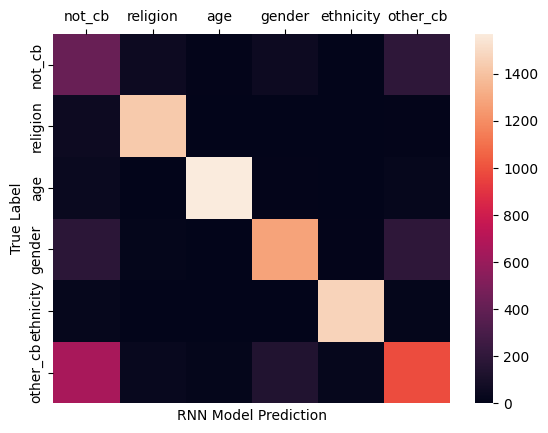

In [26]:
cm = confusion_matrix(preds, labels)
print(cm, '\n')
ax = sns.heatmap(cm, xticklabels=["not_cb", "religion", "age", "gender", "ethnicity", "other_cb"],
                yticklabels=["not_cb", "religion", "age", "gender", "ethnicity", "other_cb"])
ax.set(xlabel="RNN Model Prediction", ylabel="True Label")
ax.xaxis.tick_top()

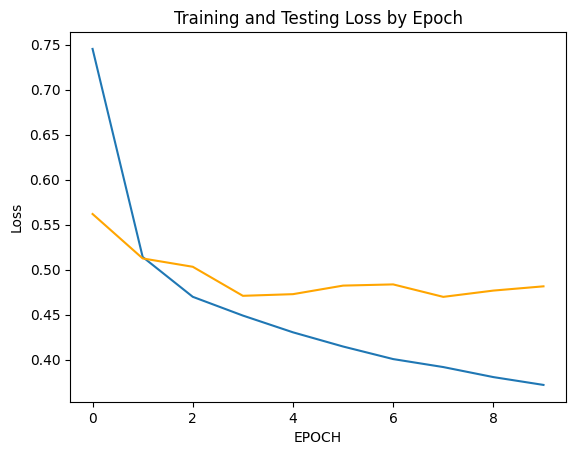

In [27]:
plt.plot(range(EPOCHS), total_training_loss)
plt.plot(range(EPOCHS), total_testing_loss, color="orange")
plt.title("Training and Testing Loss by Epoch")
plt.xlabel("EPOCH")
plt.ylabel("Loss")
plt.show()

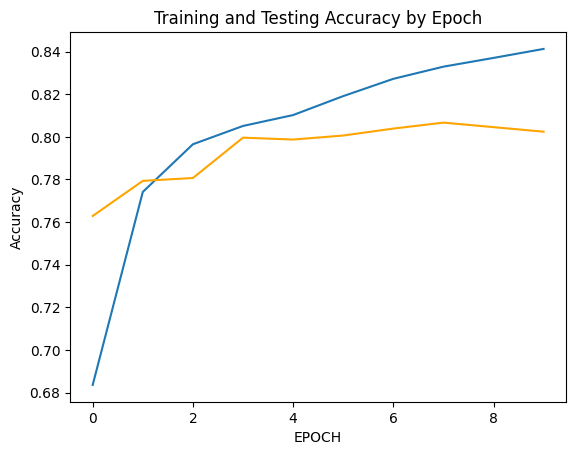

In [28]:
plt.plot(range(EPOCHS), total_training_acc)
plt.plot(range(EPOCHS), total_testing_acc, color="orange")
plt.title("Training and Testing Accuracy by Epoch")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.show()